In [ ]:
!unzip /content/sample_data/dataset.zip -d /content/


In [ ]:
!ls /content/dataset



test  train  validation


In [ ]:
!ls /content/dataset/train

Cordana  Healthy  Pestalotiopsis  Sigatoka


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

DATASET_PATH = "/content/dataset"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR = os.path.join(DATASET_PATH, "validation")
TEST_DIR = os.path.join(DATASET_PATH, "test")


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [ ]:
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 420 images belonging to 4 classes.
Found 118 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


In [ ]:
NUM_CLASSES = train_generator.num_classes
print("Classes:", train_generator.class_indices)


Classes: {'Cordana': 0, 'Healthy': 1, 'Pestalotiopsis': 2, 'Sigatoka': 3}


In [ ]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "banana_leaf_model.keras",
    monitor="val_accuracy",
    save_best_only=True
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2755 - loss: 2.2426 - val_accuracy: 0.6102 - val_loss: 1.0993
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5489 - loss: 1.1140 - val_accuracy: 0.7627 - val_loss: 0.8225
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7085 - loss: 0.7795 - val_accuracy: 0.8051 - val_loss: 0.6582
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7663 - loss: 0.6203 - val_accuracy: 0.8390 - val_loss: 0.5492
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8126 - loss: 0.5164 - val_accuracy: 0.8729 - val_loss: 0.4656
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8706 - loss: 0.3995 - val_accuracy: 0.8983 - val_loss: 0.3958
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8910 - loss: 0.3443 - val_accuracy: 0.8983 - val_loss: 0.3505
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8468 - loss: 0.3517 - val_accuracy: 0.8983 - val_loss:

In [ ]:
# Unfreeze the top layers of EfficientNet
base_model.trainable = True

fine_tune_at = int(len(base_model.layers) * 0.75)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lower LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
fine_tune_epochs = 10

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8276 - loss: 0.4288 - val_accuracy: 0.9322 - val_loss: 0.2326
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7962 - loss: 0.4878 - val_accuracy: 0.9153 - val_loss: 0.2409
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8424 - loss: 0.4421 - val_accuracy: 0.9153 - val_loss: 0.2540
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8332 - loss: 0.4892 - val_accuracy: 0.9068 - val_loss: 0.2667
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8601 - loss: 0.3734 - val_accuracy: 0.8983 - val_loss: 0.2814
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8561 - loss: 0.4080 - val_accuracy: 0.8983 - val_loss: 0.2920


test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


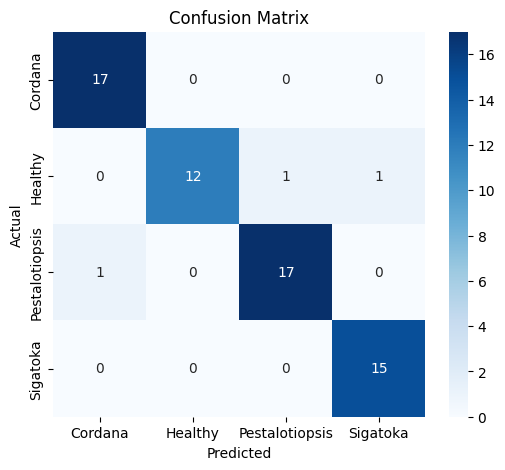

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


                precision    recall  f1-score   support

       Cordana       0.94      1.00      0.97        17
       Healthy       1.00      0.86      0.92        14
Pestalotiopsis       0.94      0.94      0.94        18
      Sigatoka       0.94      1.00      0.97        15

      accuracy                           0.95        64
     macro avg       0.96      0.95      0.95        64
  weighted avg       0.95      0.95      0.95        64



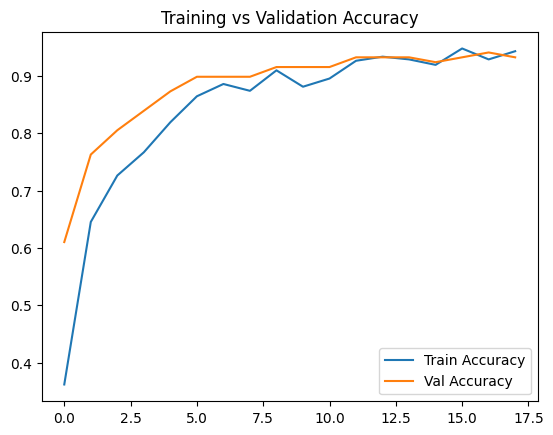

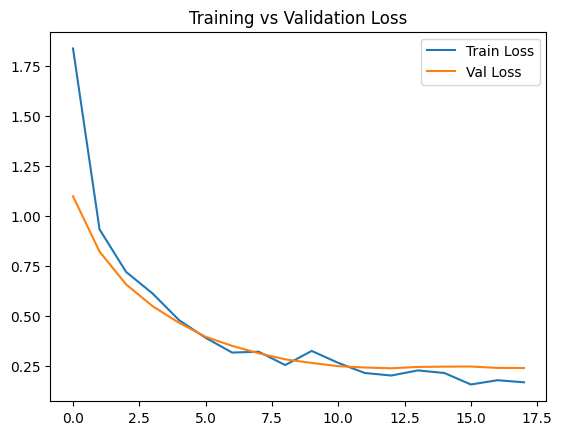

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.save("banana_leaf_final_model.keras")


In [ ]:
!ls /content

banana_leaf_final_model.keras  dataset	sample_data
banana_leaf_model.keras        drive


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load saved model
model = load_model("banana_leaf_final_model.keras")

# Load a sample image
img = image.load_img(
    "/content/dataset/test/Sigatoka/455.jpeg",
    target_size=(224, 224)
)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

class_names = list(train_generator.class_indices.keys())
print("Predicted disease:", class_names[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted disease: Sigatoka


In [ ]:
model.save("banana_leaf_final_model.keras")


In [ ]:
!ls /content


banana_leaf_final_model.keras  dataset	sample_data
banana_leaf_model.keras        drive
